# DAY1のモデル見直し
DAY2の要素を入れる前に、DAY1の実施内容に説明変数を追加することでモデルの精度向上を試みる。

In [1]:
# 必要ライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

In [2]:
# データの読み込み
df_kick_org = pd.read_csv('./data/ks-projects-201801.csv')
display(df_kick_org.head())
df_kick_org.describe()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


# DAY1の実施内容の再現
* stateがsuccessfulまたはfailedとなるレコードの抽出
* 募集期間periodの作成

In [3]:
# stateがsuccessfulまたはfailedとなるレコードの抽出
df_kick = df_kick_org.loc[(df_kick_org['state'] == 'successful') | (df_kick_org['state'] == 'failed'), :]

df_kick.loc[df_kick['state'] == 'failed', 'state'] = 0
df_kick.loc[df_kick['state'] == 'successful', 'state'] = 1

df_kick['state'].value_counts()

C:\Users\reneu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


0    197719
1    133956
Name: state, dtype: int64

In [4]:
# 募集期間periodの作成
df_kick.loc[:, 'deadline_dt'] = pd.to_datetime(df_kick['deadline'])
df_kick.loc[:, 'launched_dt'] = pd.to_datetime(df_kick['launched'])

df_kick.loc[:, 'period_dt'] = df_kick['deadline_dt'] - df_kick['launched_dt']
df_kick.loc[:, 'period'] = df_kick['period_dt'].dt.days

display(df_kick.head())

C:\Users\reneu\Anaconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,deadline_dt,launched_dt,period_dt,period
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,0,0,GB,0.0,0.0,1533.95,2015-10-09,2015-08-11 12:12:28,58 days 11:47:32,58
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,0,15,US,100.0,2421.0,30000.00,2017-11-01,2017-09-02 04:43:57,59 days 19:16:03,59
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,0,3,US,220.0,220.0,45000.00,2013-02-26,2013-01-12 00:20:50,44 days 23:39:10,44
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,0,1,US,1.0,1.0,5000.00,2012-04-16,2012-03-17 03:24:11,29 days 20:35:49,29
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,1,224,US,52375.0,52375.0,50000.00,2016-04-01,2016-02-26 13:38:27,34 days 10:21:33,34


In [5]:
# 欠損値を確認する
df_kick.isnull().sum()

ID                    0
name                  3
category              0
main_category         0
currency              0
deadline              0
goal                  0
launched              0
pledged               0
state                 0
backers               0
country               0
usd pledged         210
usd_pledged_real      0
usd_goal_real         0
deadline_dt           0
launched_dt           0
period_dt             0
period                0
dtype: int64

# nameの文字数を説明変数にする
nameに欠損値が含まれている。  
nameの文字数を説明変数とするのであれば、欠損値に0を埋めればよい。

In [6]:
# nameの文字数をname_lengthという説明変数にする
df_kick.loc[:, 'name_length'] = df_kick['name'].str.len()

# name_lengthの欠損値に0を入れる
df_kick.loc[:, 'name_length'] = df_kick['name_length'].fillna(0)

# 欠損値確認
df_kick.isnull().sum()

ID                    0
name                  3
category              0
main_category         0
currency              0
deadline              0
goal                  0
launched              0
pledged               0
state                 0
backers               0
country               0
usd pledged         210
usd_pledged_real      0
usd_goal_real         0
deadline_dt           0
launched_dt           0
period_dt             0
period                0
name_length           0
dtype: int64

In [7]:
# name_lengthの分布確認
df_kick['name_length'].value_counts()

60.0    11331
59.0     8330
58.0     7312
20.0     7201
21.0     6985
        ...  
76.0       49
77.0       47
2.0        38
1.0         7
0.0         3
Name: name_length, Length: 86, dtype: int64

<BarContainer object of 86 artists>

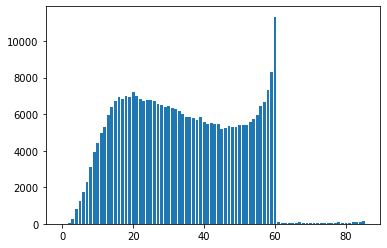

In [8]:
name_lengths = df_kick['name_length'].value_counts().keys()
name_length_values = df_kick['name_length'].value_counts()
plt.bar(name_lengths, name_length_values)

# main_categoryについて確認
一番最後にone-hot-vectorに変換する

In [9]:
df_kick['main_category'].value_counts()

Film & Video    56527
Music           45949
Publishing      35445
Games           28521
Technology      27050
Art             25641
Design          25364
Food            22054
Fashion         19775
Theater         10242
Comics           9878
Photography      9689
Crafts           7818
Journalism       4149
Dance            3573
Name: main_category, dtype: int64

<BarContainer object of 15 artists>

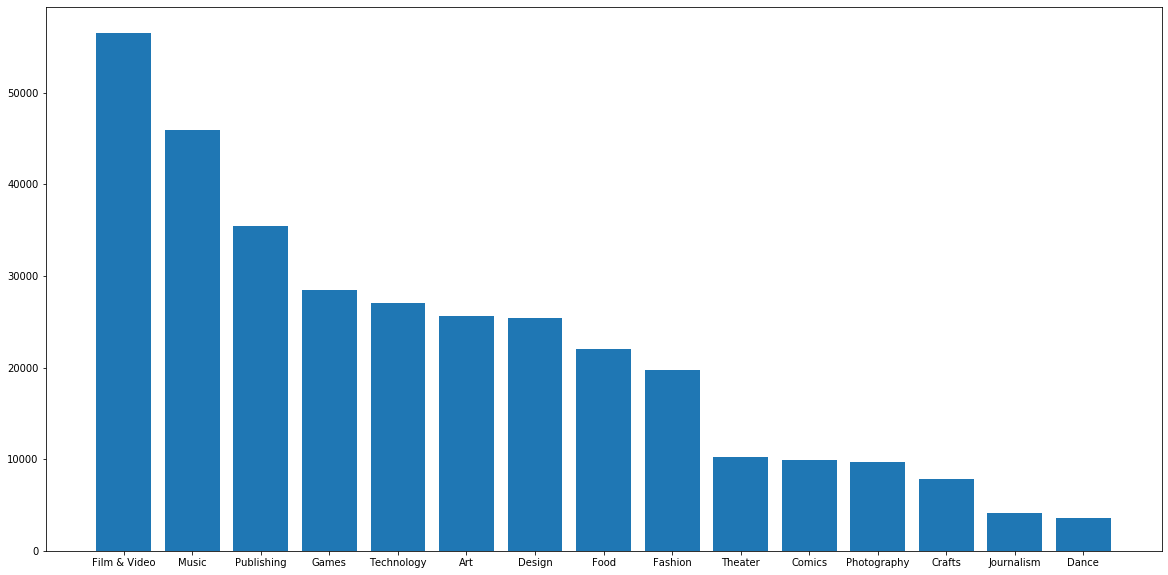

In [10]:
main_categories = df_kick['main_category'].value_counts().keys()
main_category_values = df_kick['main_category'].value_counts()
plt.figure(figsize = (20, 10))
plt.bar(main_categories, main_category_values)

# currencyについて確認
一番最後にone-hot-vectorに変換する。

In [11]:
df_kick['currency'].value_counts()

USD    261511
GBP     29476
EUR     14378
CAD     12375
AUD      6621
SEK      1510
MXN      1411
NZD      1274
DKK       929
CHF       652
NOK       584
HKD       477
SGD       454
JPY        23
Name: currency, dtype: int64

<BarContainer object of 14 artists>

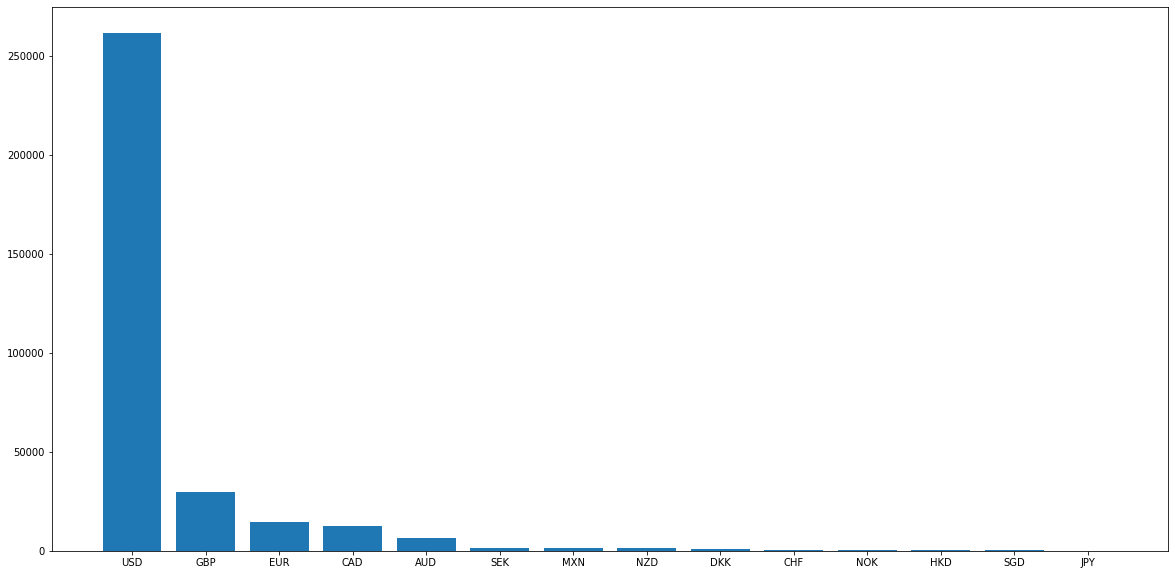

In [12]:
currencies = df_kick['currency'].value_counts().keys()
currency_counts = df_kick['currency'].value_counts()
plt.figure(figsize = (20, 10))
plt.bar(currencies, currency_counts)

# usd_goal_realを対数変換する
usd_goal_realは最大値が ``1.663614e+08``, 平均が ``4.545440e+04`` とスケールが大きい。

底が10の対数変換を行うことで、他の説明変数のスケールに近づける。

In [13]:
df_kick.loc[:, 'usd_goal_ln'] = np.log10(df_kick.loc[:, 'usd_goal_real'])
df_kick['usd_goal_ln'].describe()

count    331675.000000
mean          3.726610
std           0.726712
min          -2.000000
25%           3.301030
50%           3.698970
75%           4.176091
max           8.221053
Name: usd_goal_ln, dtype: float64

# 説明変数をone-hot-vector化する

In [14]:
df_kick = pd.get_dummies(df_kick[['state', 'main_category', 'currency', 'usd_goal_ln', 'period', 'name_length']])

df_kick.head()

,state,usd_goal_ln,period,name_length,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,...,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
0,0,3.185811,58,31.0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,4.477121,59,45.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,4.653213,44,14.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,3.698970,29,49.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,1,4.698970,34,20.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


# 説明変数の相関係数を可視化
heatmapを見る限り、以下の説明変数が*state* と負の相関が高そうである。
* usd_goal_ln
* period
* main_category_Crafts
* main_category_Fashion
* main_category_Food
* main_category_Technology
* currency_EUR

DAY3の特徴選択において、役立つ指標になるかもしれない。

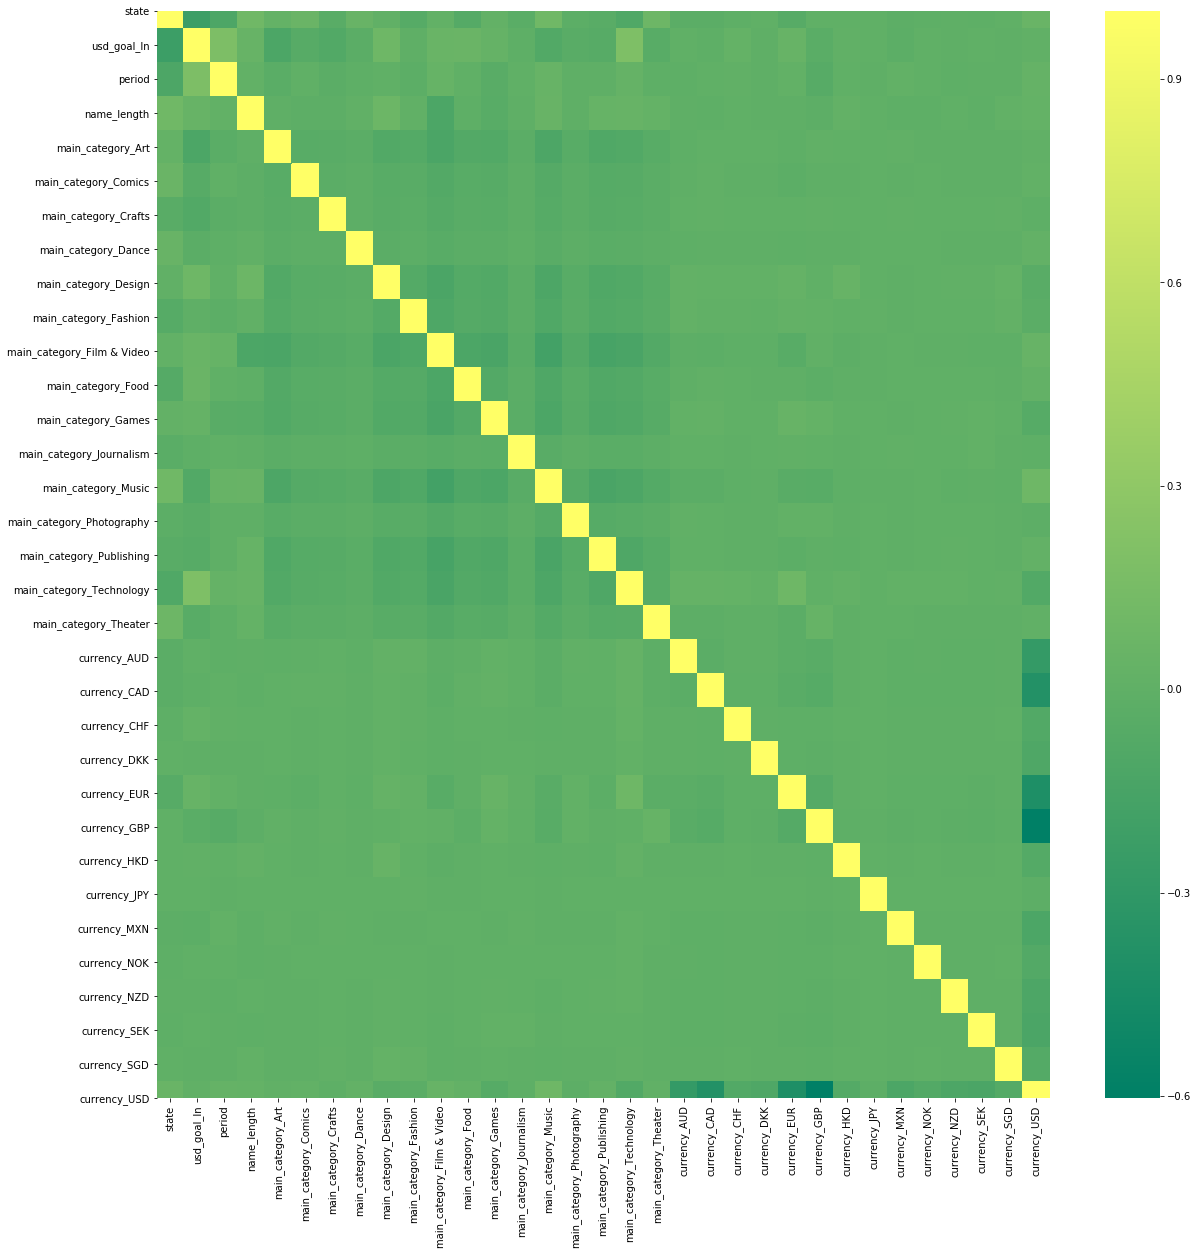

In [15]:
plt.figure(figsize=(20, 20))
sns.heatmap(df_kick.corr(), cmap = 'summer', annot = False, annot_kws = {'color': 'black', 'size': 14})
plt.show()

In [17]:
# ロジスティック回帰モデルで学習
X = df_kick[df_kick.columns[1:]].values
y = df_kick['state'].values

clf = SGDClassifier(loss = 'log', fit_intercept = True, penalty = 'none', random_state = 1234,
                   max_iter = 10000, tol = 1e-3)
clf.fit(X, y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log',
              max_iter=10000, n_iter_no_change=5, n_jobs=None, penalty='none',
              power_t=0.5, random_state=1234, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [18]:
# パイアス項と重みを出力
b = clf.intercept_[0]
print('バイアス項={:.3f}'.format(b))
for i in range(clf.coef_.shape[1]):
    print('w{:}={:.3f}'.format(i + 1, clf.coef_[0, i]))

バイアス項=1.678
w1=-0.702
w2=-0.028
w3=0.019
w4=0.115
w5=0.916
w6=-0.842
w7=1.162
w8=0.338
w9=-0.491
w10=0.383
w11=-0.399
w12=0.446
w13=-0.728
w14=0.601
w15=-0.267
w16=-0.239
w17=-0.409
w18=1.091
w19=-0.105
w20=0.026
w21=0.120
w22=0.312
w23=-0.165
w24=0.269
w25=0.841
w26=0.329
w27=-0.428
w28=-0.296
w29=0.066
w30=0.052
w31=0.298
w32=0.360


In [18]:
# stateを予測
y_est = clf.predict(X)

accuracy = accuracy_score(y, y_est)
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_est)

print('正解率 = {:.3f}'.format(accuracy * 100))
print('適合率(precision) = {:.3f}'.format(precision[1] * 100))
print('再現率(recall) = {:.3f}'.format(recall[1] * 100))
print('F1値(F1-score) = {:.3f}'.format(f1_score[1] * 100))

正解率 = 64.778
適合率(precision) = 62.927
再現率(recall) = 31.131
F1値(F1-score) = 41.655


In [19]:
# 予測値と正解のクロス集計(混同行列)
conf_mat = confusion_matrix(y, y_est)
conf_mat = pd.DataFrame(conf_mat,
                       index = ['正解：失敗', '正解：成功'],
                       columns = ['予測：失敗', '予測：成功'])
conf_mat

NameError: name 'y_est' is not defined

# DAY1のモデル見直し結果
正解率が ``48.525`` → ``64.778`` に大幅向上した。

usd_goal_realを対数変換したことで説明変数のスケールが小さくなり、外れ値の影響が少なくなったためと思われる。

# DAY2の取り組み内容
以下の順で進める。

1. 説明変数の標準化
1. 交差検証法により汎化性能を算出する
1. ロジステック回帰モデルにL2正則化を入れて過学習を防ぐ  
   ハイパーパラメータの最適値をグリッドサーチと交差検証法の組み合わせで探索する

# 説明変数の標準化
標準化が必要な説明変数を確認するため、データの統計情報を確認する。

In [20]:
df_kick.describe()

,state,usd_goal_ln,period,name_length,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,...,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
count,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,...,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000
mean,0.403877,3.726610,32.954902,34.220026,0.077308,0.029782,0.023571,0.010773,0.076472,0.059622,...,0.043350,0.088870,0.001438,0.000069,0.004254,0.001761,0.003841,0.004553,0.001369,0.788456
std,0.490674,0.726712,12.713329,15.961762,0.267079,0.169986,0.151709,0.103231,0.265753,0.236785,...,0.203643,0.284557,0.037896,0.008327,0.065085,0.041925,0.061858,0.067320,0.036972,0.408404
min,0.000000,-2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,3.301030,29.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,3.698970,29.000000,33.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,4.176091,35.000000,48.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,8.221053,91.000000,85.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


標準化が必要なのは、以下の説明変数である。
* usd_goal_ln
* period
* name_length

In [21]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
df_kick['usd_goal_ln'] = stdsc.fit_transform(df_kick[['usd_goal_ln']].values)
df_kick['period'] = stdsc.fit_transform(df_kick[['period']].values)
df_kick['name_length'] = stdsc.fit_transform(df_kick[['name_length']].values)

In [22]:
df_kick.describe()

,state,usd_goal_ln,period,name_length,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,...,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
count,331675.000000,3.316750e+05,3.316750e+05,3.316750e+05,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,...,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000
mean,0.403877,-7.357280e-17,-2.622543e-15,3.935805e-16,0.077308,0.029782,0.023571,0.010773,0.076472,0.059622,...,0.043350,0.088870,0.001438,0.000069,0.004254,0.001761,0.003841,0.004553,0.001369,0.788456
std,0.490674,1.000002e+00,1.000002e+00,1.000002e+00,0.267079,0.169986,0.151709,0.103231,0.265753,0.236785,...,0.203643,0.284557,0.037896,0.008327,0.065085,0.041925,0.061858,0.067320,0.036972,0.408404
min,0.000000,-7.880176e+00,-2.592157e+00,-2.143878e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-5.856250e-01,-3.110835e-01,-8.282322e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,-3.803453e-02,-3.110835e-01,-7.643439e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,6.185143e-01,1.608628e-01,8.633129e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,6.184635e+00,4.565695e+00,3.181356e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# 説明変数の相関係数の可視化

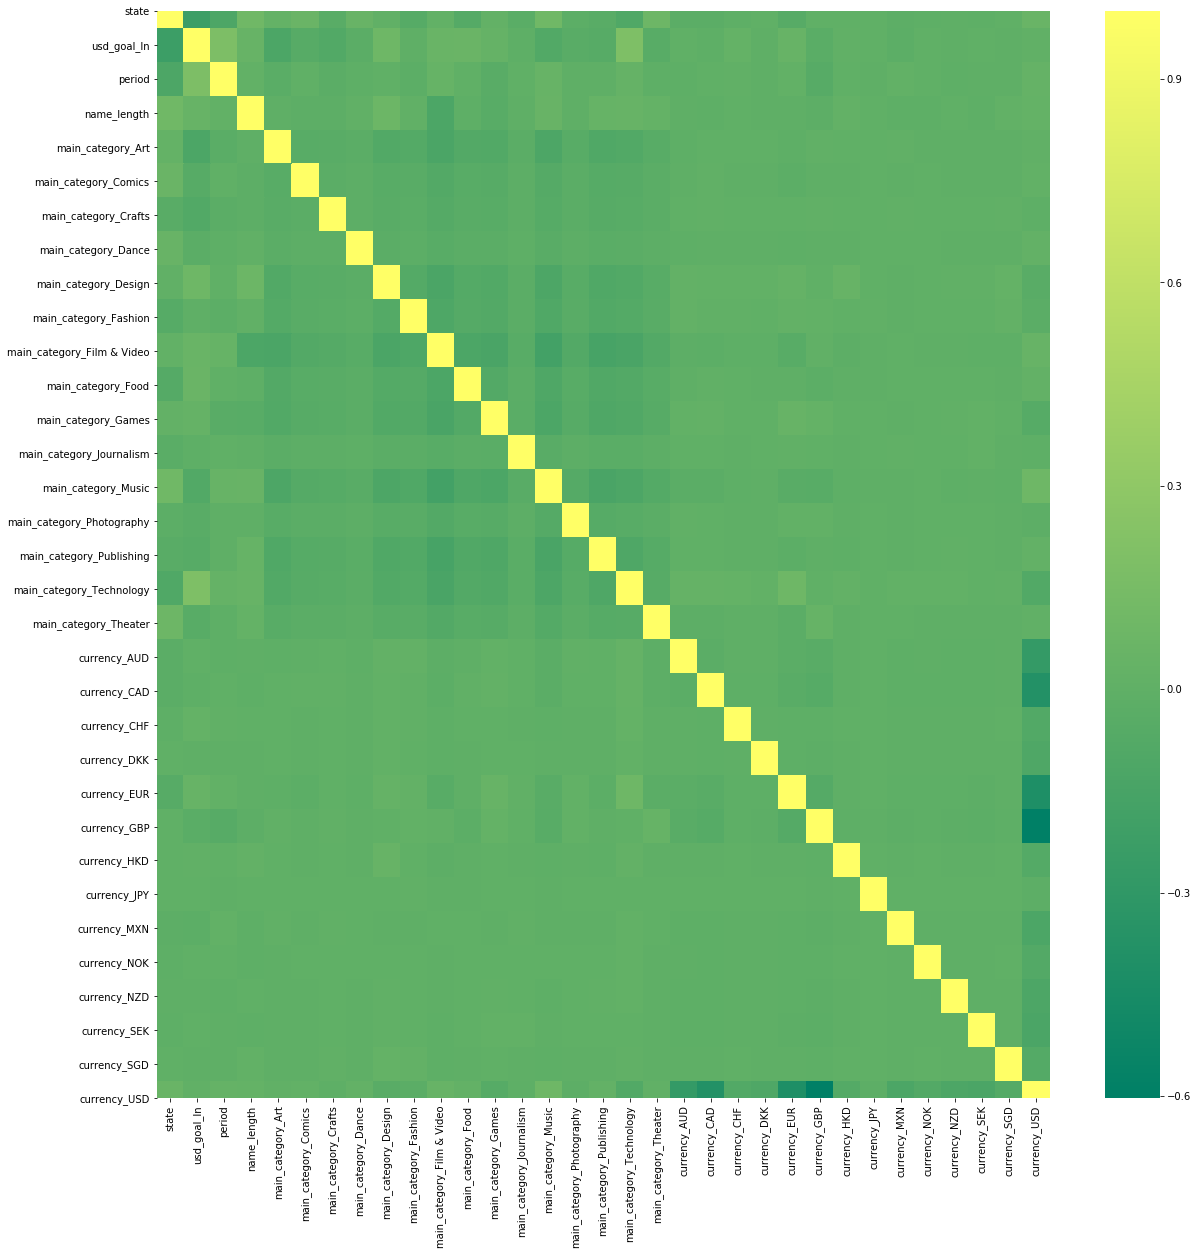

In [23]:
plt.figure(figsize=(20, 20))
sns.heatmap(df_kick.corr(), cmap = 'summer', annot = False, annot_kws = {'color': 'black', 'size': 14})
plt.show()

In [26]:
# ロジスティック回帰モデルで学習
X = df_kick[df_kick.columns[1:]].values
y = df_kick['state'].values

clf = SGDClassifier(loss = 'log', fit_intercept = True, penalty = 'none', random_state = 1234,
                   max_iter = 10000, tol = 1e-3)
clf.fit(X, y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log',
              max_iter=10000, n_iter_no_change=5, n_jobs=None, penalty='none',
              power_t=0.5, random_state=1234, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [27]:
# パイアス項と重みを出力
b = clf.intercept_[0]
print('バイアス項={:.3f}'.format(b))
for i in range(clf.coef_.shape[1]):
    print('w{:}={:.3f}'.format(i + 1, clf.coef_[0, i]))

バイアス項=-0.621
w1=-0.568
w2=-0.169
w3=0.346
w4=0.012
w5=0.669
w6=-0.913
w7=0.916
w8=0.142
w9=-0.570
w10=0.217
w11=-0.486
w12=0.281
w13=-0.781
w14=0.376
w15=-0.425
w16=-0.323
w17=-0.530
w18=0.794
w19=-0.231
w20=-0.171
w21=-0.012
w22=0.152
w23=-0.247
w24=0.082
w25=0.441
w26=0.065
w27=-0.529
w28=-0.347
w29=-0.084
w30=-0.096
w31=0.125
w32=0.231


In [29]:
# stateを予測
y_est = clf.predict(X)

accuracy = accuracy_score(y, y_est)
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_est)

print('正解率 = {:.3f}'.format(accuracy * 100))
print('適合率(precision) = {:.3f}'.format(precision[1] * 100))
print('再現率(recall) = {:.3f}'.format(recall[1] * 100))
print('F1値(F1-score) = {:.3f}'.format(f1_score[1] * 100))

正解率 = 65.177
適合率(precision) = 59.386
再現率(recall) = 43.587
F1値(F1-score) = 50.275


In [30]:
# 予測値と正解のクロス集計(混同行列)
conf_mat = confusion_matrix(y, y_est)
conf_mat = pd.DataFrame(conf_mat,
                       index = ['正解：失敗', '正解：成功'],
                       columns = ['予測：失敗', '予測：成功'])
conf_mat

,予測：失敗,予測：成功
正解：失敗,157788,39931
正解：成功,75568,58388


# 標準化を行った後の性能確認
accuracyは若干向上している。

| 指標 | DAY1見直し後 | DAY2標準化後 |
| :--- | :---: | :---: |
| accuracy | 64.778 | 65.177 |
| precision | 62.927 | 59.386 |
| recall | 31.131 | 43.587 |
| F1-score | 41.655 | 50.275 |

# 交差検証法を用いて汎化性能を算出

In [31]:
from sklearn.model_selection import KFold

n_split = 5 # 分割数

accuracy_total = 0.0
split_num = 1

for train_idx, test_idx in KFold(n_splits = n_split, shuffle = True, random_state = 1234).split(X, y):
    # 学習データとテストデータに分割
    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]
    
    # ロジスティック回帰モデルで学習
    clf = SGDClassifier(loss = 'log', fit_intercept = True, penalty = 'none', random_state = 1234,
                   max_iter = 10000, tol = 1e-3)
    clf.fit(X_train, y_train)
    
    # 学習モデルで予測
    y_est = clf.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_est)
    print("Fold {:}: 正解率 = {:.3f}".format(split_num, accuracy * 100))
    
    accuracy_total += accuracy
    split_num += 1
    
# accuracy_totalの平均値を最終的な汎化性能とする
final_accuracy = accuracy_total / n_split
print("Cross Validation accuracy = {:.3f}".format(final_accuracy * 100))

Fold 1: 正解率 = 65.367
Fold 2: 正解率 = 65.195
Fold 3: 正解率 = 65.270
Fold 4: 正解率 = 65.284
Fold 5: 正解率 = 65.290
Cross Validation accuracy = 65.281


# L2正則化を導入し、過学習を防ぐ
ロジスティック回帰モデルにL2正則化項を導入する。

L2正則化項のハイパーパラメータはグリッドサーチで最適値を探索する。  
分割数=5の交差検証法で最適なハイパーパラメータにおける汎化性能を確認する。

In [41]:
from sklearn.model_selection import GridSearchCV

params = {'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]}
# ロジスティック回帰にL2正則化項を追加したモデルで学習
clf = GridSearchCV(SGDClassifier(loss = 'log', fit_intercept = True, penalty = 'l2', 
                                 random_state = 1234, max_iter = 10000, tol = 1e-3),
                   params, cv = 5)
clf.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='log', max_iter=10000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5,
                                     random_state=1234, shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [42]:
print('L2正則化項のハイパーパラメータ最適値={:.3f}'.format(clf.best_params_['alpha']))
print('L2正則化を含めた最終的な正解率={:.3f}'.format(clf.best_score_ * 100))

L2正則化項のハイパーパラメータ最適値=0.001
L2正則化を含めた最終的な正解率=65.306


# DAY1の最終結果との比較
正解率が ``48.525`` → ``65.306`` に大幅上昇した。